In [3]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

In [4]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [5]:
from datasets import load_dataset

EuroSAT_RGB = load_dataset("blanchon/EuroSAT_RGB")  # 64x64

In [5]:
EuroSAT_RGB

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})

In [6]:
classes = EuroSAT_RGB["train"].features["label"].names
print(classes)

['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial Buildings', 'Pasture', 'Permanent Crop', 'Residential Buildings', 'River', 'SeaLake']


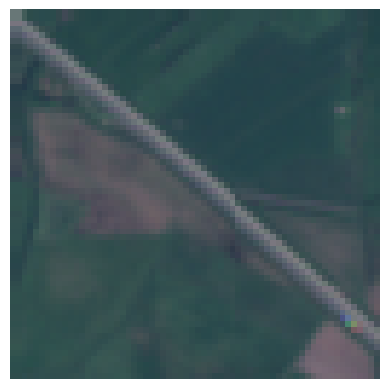

Highway


In [7]:
# pick a random image from the dataset
import random
import matplotlib.pyplot as plt

random_index = random.randint(0, len(EuroSAT_RGB["train"]))
sample = EuroSAT_RGB["train"][random_index]
plt.imshow(sample["image"])
plt.axis("off")
plt.show()
label = classes[sample["label"]]
print(label)


In [8]:
# predict label of the image
inputs = processor(
    text=classes, images=sample["image"], return_tensors="pt", padding=True
)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1).detach().numpy()

# print prob of all classes from highest to lowest prob
for i in probs.argsort()[0][::-1]:
    print(f"{classes[i]:<15} {probs[0][i]:.2f}")


Permanent Crop  0.26
Highway         0.23
Pasture         0.11
River           0.08
Forest          0.06
Industrial Buildings 0.06
SeaLake         0.06
Annual Crop     0.05
Residential Buildings 0.05
Herbaceous Vegetation 0.04


In [33]:
# calculate prediction accuracy on the validation dataset
from tqdm import tqdm

text_to_predict = [f"A satellite photo containing {c}" for c in classes]

correct = 0
total = 0
mistakes = {}
for sample in tqdm(EuroSAT_RGB["validation"]):
    inputs = processor(
        text=text_to_predict, images=sample["image"], return_tensors="pt", padding=True
    )
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1).detach().numpy()
    pred = probs.argmax()
    if pred == sample["label"]:
        correct += 1
    else:
        # print predicted prob vs actual prob
        # print(f"Predicted: {classes[pred]} ({probs[0][pred]:.2f})")
        # print(f"Actual: {classes[sample['label']]} ({probs[0][sample['label']]:.2f})")
        mistake = f"{classes[sample['label']]}->{classes[pred]}"
        # check if mistake is already in the dict
        if mistake not in mistakes:
            mistakes[mistake] = 1
        else:
            mistakes[mistake] += 1
    total += 1
    # if total == 100:
    #     break

print(f"Accuracy: {correct} / {total} = {correct / total:.2f}")
print("Mistakes:")
for mistake, count in mistakes.items():
    print(f"{mistake}: {count}")

  0%|          | 0/5400 [00:00<?, ?it/s]

100%|██████████| 5400/5400 [04:29<00:00, 20.06it/s]

Accuracy: 2401 / 5400 = 0.44
Mistakes:
Annual Crop->Permanent Crop: 175
Annual Crop->Industrial Buildings: 124
Annual Crop->Forest: 72
Annual Crop->Residential Buildings: 35
Annual Crop->Highway: 27
Annual Crop->SeaLake: 6
Annual Crop->Pasture: 5
Forest->Highway: 45
Forest->SeaLake: 48
Forest->River: 12
Forest->Pasture: 3
Forest->Industrial Buildings: 2
Forest->Residential Buildings: 1
Forest->Permanent Crop: 2
Herbaceous Vegetation->Forest: 424
Herbaceous Vegetation->SeaLake: 22
Herbaceous Vegetation->Pasture: 66
Herbaceous Vegetation->Highway: 42
Herbaceous Vegetation->Industrial Buildings: 10
Herbaceous Vegetation->Residential Buildings: 21
Herbaceous Vegetation->River: 38
Herbaceous Vegetation->Annual Crop: 3
Herbaceous Vegetation->Permanent Crop: 2
Highway->SeaLake: 4
Highway->Permanent Crop: 45
Highway->Industrial Buildings: 118
Highway->Annual Crop: 27
Highway->Residential Buildings: 5
Highway->Pasture: 5
Highway->River: 3
Highway->Forest: 2
Industrial Buildings->Residential Bui

In [36]:
# [
# 0     "Annual Crop",
# 1     "Forest",
# 2     "Herbaceous Vegetation",
# 3     "Highway",
# 4     "Industrial Buildings",
# 5     "Pasture",
# 6     "Permanent Crop",
# 7     "Residential Buildings",
# 8     "River",
# 9     "SeaLake",
# ]

revised_classes = [
    "Crop",
    "Forest",
    "Vegetation",
    "Highway",
    "Industrial Buildings",
    "Pasture",
    "Residential Buildings",
    "River",
    "Sea",
    "Lake",
]
# to lower case
revised_classes = [c.lower() for c in revised_classes]


# given predicted revised class idx and target original class idx check if prediction was correct
def is_correct(revised_class_idx, target_class_idx):
    if revised_class_idx == 0:
        return target_class_idx == 0 or target_class_idx == 6
    if revised_class_idx == 6:
        return target_class_idx == 7
    if revised_class_idx == 7:
        return target_class_idx == 8
    if revised_class_idx == 8 or revised_class_idx == 9:
        return target_class_idx == 9
    return revised_class_idx == target_class_idx


# get index of Crop class
assert is_correct(revised_classes.index("crop"), classes.index("Annual Crop"))
assert is_correct(revised_classes.index("crop"), classes.index("Permanent Crop"))
assert is_correct(revised_classes.index("forest"), classes.index("Forest"))
assert is_correct(
    revised_classes.index("vegetation"), classes.index("Herbaceous Vegetation")
)
assert is_correct(revised_classes.index("highway"), classes.index("Highway"))
assert is_correct(
    revised_classes.index("industrial buildings"), classes.index("Industrial Buildings")
)
assert is_correct(revised_classes.index("pasture"), classes.index("Pasture"))
assert is_correct(
    revised_classes.index("residential buildings"),
    classes.index("Residential Buildings"),
)
assert is_correct(revised_classes.index("river"), classes.index("River"))
assert is_correct(revised_classes.index("sea"), classes.index("SeaLake"))
assert is_correct(revised_classes.index("lake"), classes.index("SeaLake"))

In [38]:
# calculate prediction accuracy on the validation dataset
from tqdm import tqdm

text_to_predict = [f"A satellite photo containing {c}" for c in revised_classes]

correct = 0
total = 0
mistakes = {}
for sample in tqdm(EuroSAT_RGB["validation"]):
    inputs = processor(
        text=text_to_predict, images=sample["image"], return_tensors="pt", padding=True
    )
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1).detach().numpy()
    pred = probs.argmax()
    if is_correct(pred, sample["label"]):
        correct += 1
    else:
        mistake = f"{classes[sample['label']]}->{revised_classes[pred]}"
        # check if mistake is already in the dict
        if mistake not in mistakes:
            mistakes[mistake] = 1
        else:
            mistakes[mistake] += 1
    total += 1
    # if total == 100:
    # break

print(f"Accuracy: {correct} / {total} = {correct / total:.2f}")
print("Mistakes:")
for mistake, count in mistakes.items():
    print(f"{mistake}: {count}")

100%|██████████| 5400/5400 [04:46<00:00, 18.82it/s]

Accuracy: 3066 / 5400 = 0.57
Mistakes:
Annual Crop->industrial buildings: 69
Annual Crop->forest: 26
Annual Crop->highway: 10
Annual Crop->pasture: 2
Annual Crop->residential buildings: 15
Annual Crop->sea: 1
Forest->highway: 19
Forest->sea: 159
Forest->crop: 25
Forest->pasture: 2
Forest->river: 1
Forest->industrial buildings: 1
Herbaceous Vegetation->forest: 397
Herbaceous Vegetation->crop: 55
Herbaceous Vegetation->pasture: 60
Herbaceous Vegetation->highway: 40
Herbaceous Vegetation->lake: 10
Herbaceous Vegetation->industrial buildings: 7
Herbaceous Vegetation->residential buildings: 20
Herbaceous Vegetation->sea: 5
Herbaceous Vegetation->river: 31
Highway->crop: 103
Highway->industrial buildings: 110
Highway->residential buildings: 5
Highway->pasture: 2
Highway->river: 2
Highway->forest: 1
Highway->lake: 1
Industrial Buildings->residential buildings: 112
Pasture->crop: 295
Pasture->forest: 36
Pasture->lake: 2
Pasture->river: 5
Pasture->industrial buildings: 6
Permanent Crop->industr

In [11]:
# [
# 0     "Annual Crop",
# 1     "Forest",
# 2     "Herbaceous Vegetation",
# 3     "Highway",
# 4     "Industrial Buildings",
# 5     "Pasture",
# 6     "Permanent Crop",
# 7     "Residential Buildings",
# 8     "River",
# 9     "SeaLake",
# ]

revised_classes = [
    "Field",
    "Forest",
    "Highway",
    "Buildings",
    "body of water",
]
# to lower case
revised_classes = [c.lower() for c in revised_classes]


mapping = {}
mapping[revised_classes.index("field")] = set([0, 2, 5, 6])
mapping[revised_classes.index("forest")] = set([1])
mapping[revised_classes.index("highway")] = set([3])
mapping[revised_classes.index("buildings")] = set([4, 7])
mapping[revised_classes.index("body of water")] = set([8, 9])


# given predicted revised class idx and target original class idx check if prediction was correct
def is_correct(revised_class_idx, target_class_idx):
    return target_class_idx in mapping[revised_class_idx]


# get index of Crop class
assert is_correct(revised_classes.index("field"), classes.index("Annual Crop"))
assert is_correct(revised_classes.index("field"), classes.index("Permanent Crop"))
assert is_correct(revised_classes.index("forest"), classes.index("Forest"))
assert is_correct(
    revised_classes.index("field"), classes.index("Herbaceous Vegetation")
)
assert is_correct(revised_classes.index("highway"), classes.index("Highway"))
assert is_correct(
    revised_classes.index("buildings"), classes.index("Industrial Buildings")
)
assert is_correct(revised_classes.index("field"), classes.index("Pasture"))
assert is_correct(
    revised_classes.index("buildings"),
    classes.index("Residential Buildings"),
)
assert is_correct(revised_classes.index("body of water"), classes.index("River"))
assert is_correct(revised_classes.index("body of water"), classes.index("SeaLake"))
assert is_correct(revised_classes.index("body of water"), classes.index("SeaLake"))

In [41]:
# calculate prediction accuracy on the validation dataset
from tqdm import tqdm

text_to_predict = [f"A satellite photo containing {c}" for c in revised_classes]

correct = 0
total = 0
mistakes = {}
for sample in tqdm(EuroSAT_RGB["validation"]):
    inputs = processor(
        text=text_to_predict, images=sample["image"], return_tensors="pt", padding=True
    )
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1).detach().numpy()
    pred = probs.argmax()
    if is_correct(pred, sample["label"]):
        correct += 1
    else:
        mistake = f"{classes[sample['label']]}->{revised_classes[pred]}"
        # check if mistake is already in the dict
        if mistake not in mistakes:
            mistakes[mistake] = 1
        else:
            mistakes[mistake] += 1
    total += 1
    # if total == 100:
    #     break

print(f"Accuracy: {correct} / {total} = {correct / total:.2f}")
print("Mistakes:")
for mistake, count in mistakes.items():
    print(f"{mistake}: {count}")

100%|██████████| 5400/5400 [04:20<00:00, 20.69it/s]

Accuracy: 3134 / 5400 = 0.58
Mistakes:
Annual Crop->buildings: 58
Annual Crop->forest: 30
Annual Crop->highway: 6
Forest->highway: 10
Forest->field: 262
Forest->body of water: 3
Forest->buildings: 1
Herbaceous Vegetation->forest: 370
Herbaceous Vegetation->buildings: 43
Herbaceous Vegetation->highway: 32
Herbaceous Vegetation->body of water: 2
Highway->field: 158
Highway->buildings: 39
Highway->forest: 3
Industrial Buildings->field: 15
Industrial Buildings->highway: 1
Pasture->forest: 40
Pasture->highway: 1
Permanent Crop->buildings: 109
Permanent Crop->forest: 27
Permanent Crop->highway: 4
Residential Buildings->field: 8
Residential Buildings->forest: 4
Residential Buildings->highway: 5
River->field: 304
River->highway: 68
River->buildings: 88
River->forest: 30
SeaLake->field: 352
SeaLake->forest: 179
SeaLake->highway: 8
SeaLake->buildings: 6


In [19]:
# pick a random image from the dataset
import random
import matplotlib.pyplot as plt

random_index = random.randint(0, len(EuroSAT_RGB["train"]))
sample = EuroSAT_RGB["train"][random_index]

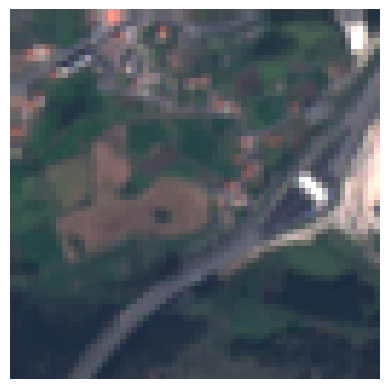

Highway
Residential Buildings 0.43
Industrial Buildings 0.22
Highway         0.17
Pasture         0.06
Permanent Crop  0.04
SeaLake         0.02
Herbaceous Vegetation 0.02
River           0.02
Forest          0.02
Annual Crop     0.01


In [20]:
plt.imshow(sample["image"])
plt.axis("off")
plt.show()
label = classes[sample["label"]]
print(label)
# predict label of the image
inputs = processor(
    text=classes, images=sample["image"], return_tensors="pt", padding=True
)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1).detach().numpy()

# print prob of all classes from highest to lowest prob
for i in probs.argsort()[0][::-1]:
    print(f"{classes[i]:<15} {probs[0][i]:.2f}")

In [21]:
text_to_predict = [f"A satellite photo containing {c}" for c in revised_classes]
inputs = processor(
    text=text_to_predict, images=sample["image"], return_tensors="pt", padding=True
)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1).detach().numpy()
pred = probs.argmax()

print(f"Predicted: {revised_classes[pred]} ({probs[0][pred]:.2f})")

Predicted: highway (0.45)
